# Using xgboost regression trees to estimate severity of claims

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import data 
train_raw = pd.read_csv('../data/train-allstate.csv')
test_raw = pd.read_csv('../data/test-allstate.csv')
train_test_raw = pd.concat((train_raw, test_raw)).reset_index(drop=True)

features = [x for x in train_test_raw.columns if x not in ['id', 'loss']]
cat_features = [x for x in train_test_raw.select_dtypes(include=['O']).columns if x not in ['id', 'loss']]
num_features = [x for x in train_test_raw.select_dtypes(exclude=['O']).columns if x not in ['id', 'loss']]

In [3]:
# save important info
targets_log = np.log(train_raw['loss'])
out_ids = test_raw['id']
ntrain = train_raw.shape[0]

# cut columns with info stored elsewhere
train_test = train_test_raw.drop(['id', 'loss'], axis=1)


In [4]:
# factorize or one hot code categorical columns
# couldn't one hot code because of memory issues
# complex factorize to make it so number for AA is after Z
def complex_factorize(df, feature):
    ser = pd.Series(df[feature].unique())
    func = lambda x: sorted(x.values.ravel())
    arr = np.hstack(ser.groupby(ser.str.len()).apply(func).values)
    return pd.factorize(arr)

def handle_cat_columns(train_test=train_test, cat_handling='factorize'):
    new_dat = train_test.copy()
    if cat_handling == 'factorize':
        print "complex factorizing categorical features"
        for feat in cat_features:
            val, ser = complex_factorize(new_dat, feat)
            new_dat[feat] = new_dat[feat].replace(ser, val)
    elif cat_handling == 'onehot':
        print "one hot coding categorical features"
        new_dat = pd.concat([new_dat, pd.get_dummies(new_dat, prefix=cat_features)],axis=1)
        new_dat = new_dat.drop(cat_features, 1)
    else:
        raise Exception('cat_handling Value Error')
    return new_dat

In [5]:
def preprocess_dat(train_test_dat, ntrain=ntrain):
    # separate data
    train = train_test_dat.iloc[:ntrain,:]
    test = train_test_dat.iloc[ntrain:,:]
    
    # scale data
    scaler = StandardScaler()
    scaler.fit(train_test_dat)
    train = scaler.transform(train)
    test = scaler.transform(test)
    return train, test

In [6]:
def run_model(train, test, outputfile, params, folds=5, early_stopping=25, out_ids=out_ids, targets_log=targets_log):
    d_test = xgb.DMatrix(test)
    # variables to track while running
    mae_folds = 0 # sum of MAE accross folds
    best_model_folds = [] # best model from each fold
    pred_folds = 0 # sum of predicted loss across folds

    # start CV loop
    kf = KFold(ntrain, n_folds=folds)
    for i, (train_index, val_index) in enumerate(kf):
        print('\n Fold %d\n' % (i + 1))
        # cut data for each fold from the training data
        X_train, X_val = train[train_index], train[val_index]
        y_train, y_val = targets_log[train_index], targets_log[val_index]

        # make into dmatricies
        d_train = xgb.DMatrix(X_train, label=y_train)
        d_val = xgb.DMatrix(X_val, label=y_val)
        
        # model
        clf = xgb.train(params,
                       d_train,
                       100000, # high number of rounds, just stop when it isn't getting better
                       [(d_train, 'train'), (d_val, 'eval')],
                       early_stopping_rounds=early_stopping)

        # Evaulate on fold's validation data
        mae_fold = mean_absolute_error(np.exp(y_val),
                                       np.exp(clf.predict(d_val, ntree_limit=clf.best_ntree_limit)))

        # Get fold's prediction of test data's losses
        pred_fold = np.exp(clf.predict(d_test, ntree_limit=clf.best_ntree_limit))

        #keep track of sums to average later and of best estimator from fold
        mae_folds += mae_fold
        pred_folds += pred_fold
        best_model_folds.append(clf.best_iteration)

    # Average predictions and MAE to evaluate
    pred = pred_folds / folds
    mae = mae_folds / folds
    print('\n Average eval-MAE: %.6f' % mae)

    # Output predictions
    output = pd.DataFrame(pred, columns=['loss'])
    output['id'] = out_ids
    output = output.set_index('id')
    output.to_csv(outputfile, encoding='utf-8')
    
    # Plot feature importances for more exploration
    feat_imp = pd.Series(clf.get_fscore()).sort_values(ascending=False)

    
    return mae, feat_imp

In [7]:
train, test = preprocess_dat(handle_cat_columns(cat_handling='factorize'))

complex factorizing categorical features


In [8]:
# Avg MAE ~ 1144.9
params ={
    'booster': 'gbtree',
    'colsample_bytree': 0.3085,
    'eta': 0.1,
    'eval_metric': 'mae',
    'gamma': 0.529,
    'max_delta_step': 0,
    'max_depth': 7,
    'min_child_weight': 4.2922,
    'objective': 'reg:linear',
    'random_state': 1001,
    'silent': 1,
    'subsample': 0.993}

mae_fact, feat_imp = run_model(train, test, 'fact_run.csv', params)



 Fold 1

[0]	train-mae:6.46764	eval-mae:6.46368
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 25 rounds.
[1]	train-mae:5.82105	eval-mae:5.81686
[2]	train-mae:5.23911	eval-mae:5.23477
[3]	train-mae:4.71539	eval-mae:4.71079
[4]	train-mae:4.24403	eval-mae:4.2395
[5]	train-mae:3.81987	eval-mae:3.81527
[6]	train-mae:3.43807	eval-mae:3.43339
[7]	train-mae:3.09451	eval-mae:3.08977
[8]	train-mae:2.78539	eval-mae:2.78061
[9]	train-mae:2.50732	eval-mae:2.50263
[10]	train-mae:2.2572	eval-mae:2.25238
[11]	train-mae:2.03239	eval-mae:2.02741
[12]	train-mae:1.83051	eval-mae:1.82537
[13]	train-mae:1.64951	eval-mae:1.64422
[14]	train-mae:1.48758	eval-mae:1.48205
[15]	train-mae:1.34313	eval-mae:1.33776
[16]	train-mae:1.21492	eval-mae:1.20984
[17]	train-mae:1.10187	eval-mae:1.09725
[18]	train-mae:1.00283	eval-mae:0.998685
[19]	train-mae:0.916303	eval-mae:0.912562
[20]	train-mae:0.841467	eval-mae:0.838073
[21]	train-mae:0

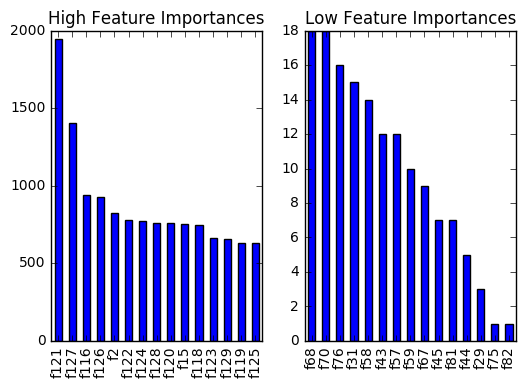

In [9]:
fig, axs = plt.subplots(1,2)
feat_imp[:15].plot(kind='bar', title='High Feature Importances', ax=axs[0])
feat_imp[-15:].plot(kind='bar', title='Low Feature Importances', ax=axs[1])